### Analyzing the World Bank's Twitter Feed, Judy Yang, DAT10 Project
### Part 4. Text Analysis

1. Tokenization, word counts

2. Prediction Linear Regression

3. Topic Modelling

4. Predict High/Low Popular Tweets

5. Term Frequency

6. Sentiment Analysis

In [31]:
pwd

u'/Users/judyyang/Documents/GA_DS_course/Final_Project/notebooks'

In [32]:
from datetime import datetime
import time
import json
import operator 
import preprocess
from collections import Counter
#from textblob import TextBlob

import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#% sign 

import numpy as np
import scipy as sp
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from gensim import corpora, models, similarities
from collections import defaultdict
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer

from ttp import ttp

pd.options.display.max_columns = 50
pd.options.display.max_rows= 50
pd.options.display.width= 120

In [33]:
# Create excel to save outputs from this notebook
writer = ExcelWriter('./data/Project04_outputs_worldbank_21feb2016.xlsx')

In [34]:
wb = pd.read_pickle('./data/WorldBank_all_processed_17feb_2016')

In [35]:
wb = wb[(wb.is_RT==0)]
wb.shape

(71287, 21)

In [36]:
wb=wb[wb.user_screen_name=="WorldBank"]

In [37]:
wb['favorite75']=np.where(wb.favorite_count>=49, 1, 0)
wb['retweet75']=np.where(wb.retweet_count>=70, 1, 0)
wb['favorite0']=np.where(wb.favorite_count>0, 1, 0)
wb['retweet0']=np.where(wb.retweet_count>0, 1, 0)

In [38]:
wb.favorite75.describe()

count    2830.000000
mean        0.259364
std         0.438363
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: favorite75, dtype: float64

In [39]:
wb.retweet75.describe()

count    2830.000000
mean        0.258304
std         0.437779
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: retweet75, dtype: float64

In [40]:
wb = wb.reset_index()

In [41]:
list(wb.columns.values)

['index',
 u'id',
 u'user_screen_name',
 u'created_at',
 u'favorite_count',
 u'retweet_count',
 u'text',
 'length',
 'is_RT',
 'has_ht',
 'has_link',
 'has_at',
 'tags',
 'users',
 'text_clean',
 'has_retweet',
 'has_favorite',
 'year',
 'year_cat',
 'year_month',
 'hour',
 'fav_RT_ratio',
 'favorite75',
 'retweet75',
 'favorite0',
 'retweet0']

### Check top tweets

In [42]:
#Save the tweets with the top retweets and favorite counts
top_retweets=wb[(wb.retweet_count>=300)].sort_values("retweet_count", ascending=False)
top_retweets.to_excel(writer,'top_retweets')

top_fav=wb[(wb.favorite_count>=300)].sort_values("favorite_count", ascending=False)
top_fav.to_excel(writer,'top_favs')

### Calculate the likelihood of top favorite and retweet for each word/token 

In [43]:
# instantiate the vectorizer
vect = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(1,1))

# learn the vocabulary of ALL messages and save it
vect.fit(wb.text_clean)
#this is a list
all_tokens = vect.get_feature_names()
vect

CountVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [44]:
# create separate DataFrames for high retweet and low retweet
rhi = wb[wb.retweet75==1]
rlo = wb[wb.retweet75==0]

fhi = wb[wb.favorite75==1]
flo = wb[wb.favorite75==0]

In [45]:
# create document-term matrices for retweet high and low
rhi_dtm = vect.transform(rhi.text_clean)
rlo_dtm = vect.transform(rlo.text_clean)

# count how many times EACH token appears across ALL retweet high/low messages
rhi_counts = np.sum(rhi_dtm.toarray(), axis=0)
rlo_counts = np.sum(rlo_dtm.toarray(), axis=0)

In [46]:
# create document-term matrices for favorite high and low
fhi_dtm = vect.transform(fhi.text_clean)
flo_dtm = vect.transform(flo.text_clean)

# count how many times EACH token appears across ALL favorite high/low messages
fhi_counts = np.sum(fhi_dtm.toarray(), axis=0)
flo_counts = np.sum(flo_dtm.toarray(), axis=0)

In [47]:
# create a DataFrame of tokens with their separate favorite high and low counts
token_counts = pd.DataFrame({'token':all_tokens, 'flo':flo_counts, 'fhi':fhi_counts, 'rlo':rlo_counts, 'rhi':rhi_counts})

# add one to retweet/favorite high and low counts to avoid dividing by zero (in the step that follows)
#pseudo counts
token_counts['rlo'] = token_counts.rlo + 1
token_counts['rhi'] = token_counts.rhi + 1
token_counts['flo'] = token_counts.flo + 1
token_counts['fhi'] = token_counts.fhi + 1

# calculate ratio of high-low for each token
token_counts['fav_ratio'] = token_counts.fhi / token_counts.flo
token_counts['retweet_ratio'] = token_counts.rhi / token_counts.rlo

In [48]:
#export to excel
cols=['token', 'fhi', 'flo','rhi', 'rlo', 'fav_ratio', 'retweet_ratio']
token_counts=token_counts[cols]
token_counts.to_excel(writer,'ratio_tokens_all_textclean_0')
token_counts.sort_values("fav_ratio", ascending=False).head()

,token,fhi,flo,rhi,rlo,fav_ratio,retweet_ratio
3278,phones,7,1,7,1,7.0,7.00
1045,crowdfunding,6,1,5,2,6.0,2.50
554,bigdata,6,1,3,4,6.0,0.75
2940,morocco,11,2,8,5,5.5,1.60
3140,orangetheworld,5,1,5,1,5.0,5.00


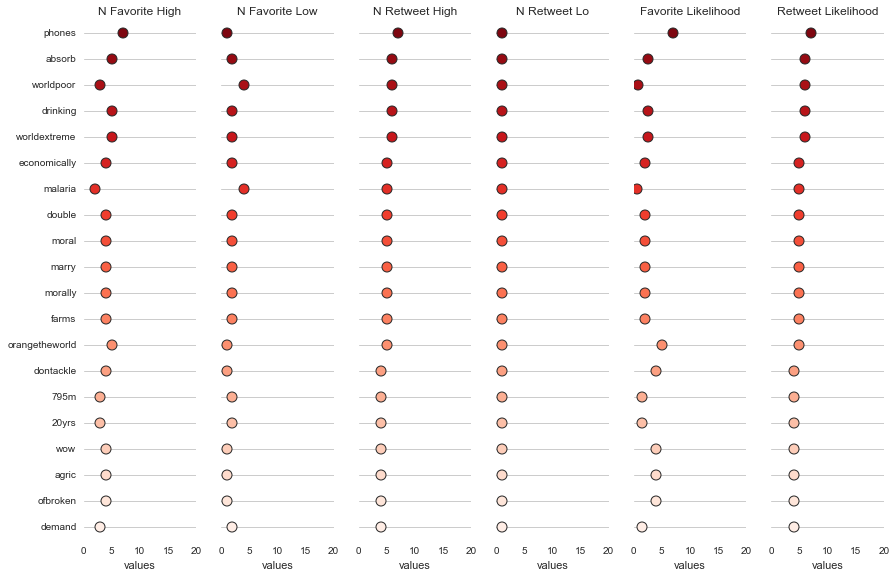

In [49]:
# Make the PairGrid
token_counts_graph=token_counts.sort_values("retweet_ratio", ascending=False).head(20)

sns.set(style="whitegrid")

g = sns.PairGrid(token_counts_graph.sort_values("retweet_ratio", ascending=False),
                 x_vars=token_counts_graph.columns[1:], y_vars=["token"],
                 size=8, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="Reds_r", edgecolor="gray")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 20), xlabel="values", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["N Favorite High", "N Favorite Low", "N Retweet High", "N Retweet Lo", "Favorite Likelihood", "Retweet Likelihood"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

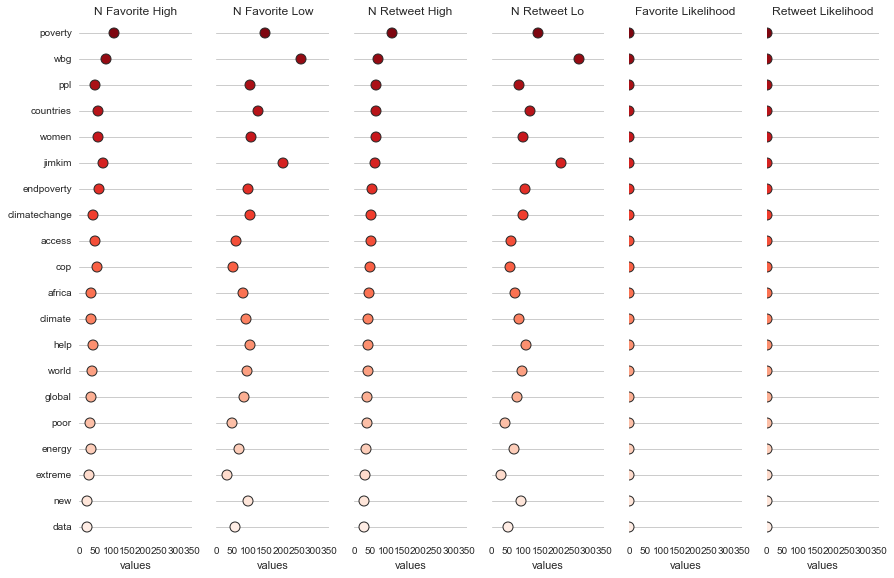

In [50]:
# Make the PairGrid
token_counts_graph=token_counts.sort_values("rhi", ascending=False).head(20)

sns.set(style="whitegrid")

g = sns.PairGrid(token_counts_graph.sort_values("rhi", ascending=False),
                 x_vars=token_counts_graph.columns[1:], y_vars=["token"],
                 size=8, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="Reds_r", edgecolor="gray")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 350), xlabel="values", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["N Favorite High", "N Favorite Low", "N Retweet High", "N Retweet Lo", "Favorite Likelihood", "Retweet Likelihood"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

### Term Frequency and Inverse Document Frequency:
- **What:** Computes "relative frequency" that a word appears in a document compared to its frequency across all documents
- **Why:** More useful than "term frequency" for identifying "important" words in each document (high frequency in that document, low frequency in other documents)
- **Notes:** Used for search engine scoring, text summarization, document clustering

In [51]:
# create a document-term matrix using TF-IDF
vect = TfidfVectorizer(stop_words='english',analyzer='word', ngram_range=(1,1))
dtm = vect.fit_transform(wb.tags)
features = vect.get_feature_names()
dtm.shape

(2830, 713)

In [52]:
#See the dtm matrix
#pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names())

### Topic Modelling 

In [53]:
X=wb.text_clean

In [54]:
stoplist = set(CountVectorizer(stop_words='english').get_stop_words() )

In [55]:
texts = [[word for word in document.lower().split() if word not in stoplist] for document in list(X)]

# count up the frequency of each word
frequency = defaultdict(int)
for text in texts:
     for token in text:
         frequency[token] += 1    
        
# (2) remove words that only occur a small number of times, fixing a feature space that's needlessly big.
# once in the whole corpus, not just once in a single document

texts = [[token for token in text if frequency[token] > 1] for text in texts]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda = models.LdaModel(corpus, id2word=dictionary, num_topics=10, alpha = 'auto')
#lda.show_topics()



In [56]:
lda.top_topics(corpus, num_words=5)

[([(0.031163111296558806, u'join'),
   (0.021434236600787651, u'wbg'),
   (0.018614664325007572, u'jimkim'),
   (0.013181711366740779, u'globalcitizen'),
   (0.011344912425441419, u'poverty')],
  -34.930151701943913),
 ([(0.017049501922511465, u'event'),
   (0.014257306291833914, u'live'),
   (0.011625716052991604, u'join'),
   (0.011301895537454167, u'sri'),
   (0.011222708478502484, u'mulyani')],
  -37.046817475310036),
 ([(0.014854600634949153, u'new'),
   (0.013827796321219249, u'worldbank'),
   (0.01180388140037401, u'help'),
   (0.011025312214437786, u'data'),
   (0.010694459904118749, u'endpoverty')],
  -38.948062372131467),
 ([(0.021010039959166813, u'wbg'),
   (0.016776389355340038, u'jimkim'),
   (0.013477753060845249, u'carbon'),
   (0.013031670093977703, u'climatechange'),
   (0.01198247914925245, u'unga')],
  -45.191068299810958),
 ([(0.033993877470651863, u'wbg'),
   (0.028782121931809408, u'jimkim'),
   (0.015196378336113823, u'climate'),
   (0.015058517876068175, u'help

** Topic model only the top retweet and favorite tweets **

In [57]:
X=wb.text_clean[wb.retweet_count>30]

In [58]:
texts = [[word for word in document.lower().split() if word not in stoplist] for document in list(X)]

# count up the frequency of each word
frequency = defaultdict(int)
for text in texts:
     for token in text:
         frequency[token] += 1 
        
# remove words that only occur a small number of times, fixing a feature space that's needlessly big.
# once in the whole corpus, not just once in a single document
texts = [[token for token in text if frequency[token] > 1] for text in texts]


dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

lda = models.LdaModel(corpus, id2word=dictionary, num_topics=10, alpha = 'auto')

lda.print_topics()

[u'0.037*djokernole + 0.035*servingecd + 0.022*pmr + 0.021*children + 0.018*accesstoinformation + 0.017*climateaction + 0.015*wbg + 0.014*join + 0.014*climatedeal + 0.013*watch',
 u'0.019*thirsty + 0.018*cities + 0.015*agriculture + 0.014*joins + 0.013*african + 0.011*ppl + 0.010*wwweek + 0.010*africaopendata + 0.010*youthbiz + 0.010*congrats',
 u'0.035*singapore + 0.030*musicnegrito + 0.030*carbon + 0.020*music4dev + 0.020*india + 0.017*electricity + 0.016*transport + 0.011*citizen + 0.010*newdelhi + 0.010*tatapower',
 u'0.047*specialist + 0.025*governments + 0.023*goodgov + 0.016*safetynets + 0.016*energyaccess + 0.014*yrs + 0.013*bank + 0.012*help + 0.011*procurement + 0.011*world',
 u'0.026*carbon + 0.014*affordable + 0.014*good + 0.013*electricity + 0.013*kenyaslums + 0.013*south + 0.013*change + 0.012*countries + 0.012*climate + 0.011*wbg',
 u'0.024*poverty + 0.013*extreme + 0.012*climate + 0.011*action + 0.010*america + 0.009*address + 0.009*data + 0.009*means + 0.008*improve + 

In [59]:
lda.top_topics(corpus, num_words=5)

[([(0.037706413463304563, u'apply'),
   (0.030565560766038016, u'encouraged'),
   (0.024747310750281748, u'transport'),
   (0.01576716675470707, u'women'),
   (0.015227856287971896, u'work')],
  -25.069725324580588),
 ([(0.019088364032240294, u'thirsty'),
   (0.018332201589974707, u'cities'),
   (0.015178285569587842, u'agriculture'),
   (0.014233760212261628, u'joins'),
   (0.012830525220207523, u'african')],
  -31.315620186101846),
 ([(0.037189536823988838, u'djokernole'),
   (0.035192828706442122, u'servingecd'),
   (0.021816327229804332, u'pmr'),
   (0.021238457197596521, u'children'),
   (0.01821183324913439, u'accesstoinformation')],
  -33.702022954030902),
 ([(0.047261784173318111, u'specialist'),
   (0.024689331680281951, u'governments'),
   (0.023077604582193566, u'goodgov'),
   (0.016361371631657091, u'safetynets'),
   (0.016150457623216104, u'energyaccess')],
  -35.725047558568733),
 ([(0.014852714848371997, u'damage'),
   (0.013207576799809068, u'poverty'),
   (0.0121619389

### Predictions: what determines high retweets and favorites?

** Linear Regression **

How much of retweet or favorite responses can be explained by non-text

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

In [61]:
# Exercise :  define a function that accepts a list of features and returns testing RMSE
def train_test_rmse(cols):
   
    X = wb[cols]
    y= wb.favorite_count
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)
    
    # instantiate and fit
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    # print the coefficients
    true=y_test
    pred=linreg.predict(X_test)
    rmse=np.sqrt(metrics.mean_squared_error(true, pred))
    
    return rmse

In [62]:
# compare different sets of features
#1) has_at 
print train_test_rmse(['has_at'])

#2) has a hashtag
print train_test_rmse(['has_ht'])

#3) has a hashtag
print train_test_rmse(['has_link'])

#4) has_at, has a hashtag, has a link, is a RT
print train_test_rmse(['has_at', 'has_ht', 'has_link'])

41.7834073067
41.9224317737
41.897582725
41.7904268735


Comparing testing RMSE with null RMSE
Null RMSE is the RMSE that could be achieved by always predicting the mean response value. It is a benchmark against which you may want to measure your regression model.

In [63]:
print train_test_rmse(['has_at'])

41.7834073067


**Logistic Regression**

In [64]:
# train a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [65]:
cols=['has_at', 'has_ht', 'has_link']

In [66]:
# split the new DataFrame into training and testing sets
X= wb[cols]
y=wb.retweet75
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg.fit(X_train, y_train)

# make predictions for testing set
y_pred_class = logreg.predict(X_test)

# calculate testing accuracy
print metrics.accuracy_score(y_test, y_pred_class)

0.721751412429


In [67]:
# null accuracy
y_test.value_counts().head(1) / len(y_test)

0    0.721751
Name: retweet75, dtype: float64

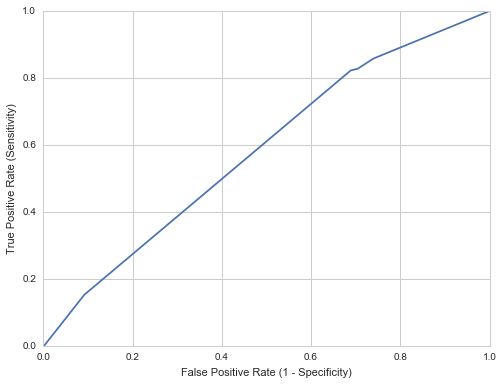

In [68]:
# predict probability of survival
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1195ca690>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11dd60d50>], dtype=object)

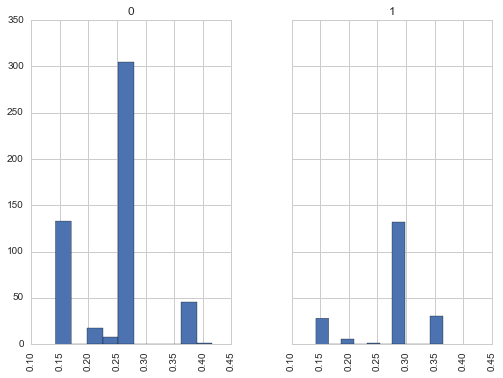

In [69]:
# histogram of predicted probabilities grouped by actual response value
df = pd.DataFrame({'probability':y_pred_prob, 'actual':y_test})
df.hist(column='probability', by='actual', sharex=True, sharey=True)

In [70]:
# calculate AUC
print metrics.roc_auc_score(y_test, y_pred_prob)

0.582087476532


In [71]:
# calculate cross-validated AUC
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.59033245389229538

** Naive Bayes, predict top retweet/favorite or not **

In [72]:
# split the new DataFrame into training and testing sets
X=wb.text
#y=wb.retweet75
y=wb.favorite75

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [73]:
type(y_test)

pandas.core.series.Series

In [74]:
# use CountVectorizer to create document-term matrices from X_train and X_test
# remove English stop words
vect = CountVectorizer(stop_words='english', lowercase=True)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test) 

In [75]:
# train a logistic regression model
logreg.fit(X_train_dtm, y_train)

# make predictions for testing set
y_pred_class = logreg.predict(X_test_dtm)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]

# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)

0.771186440678


In [76]:
# calculate null accuracy
y_test_binary = np.where(y_test==1, 1, 0)
max(y_test_binary.mean(), 1 - y_test_binary.mean())

0.75282485875706218

In [77]:
# define a function that accepts a vectorizer and calculates the accuracy
def tokenize_test(vect):
    X_train_dtm = vect.fit_transform(X_train)
    print 'Features: ', X_train_dtm.shape[1]
    X_test_dtm = vect.transform(X_test)
    logreg.fit(X_train_dtm, y_train)
    y_pred_class = logreg.predict(X_test_dtm)
    print 'Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)

In [78]:
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))
tokenize_test(vect)

Features:  30392
Accuracy:  0.778248587571


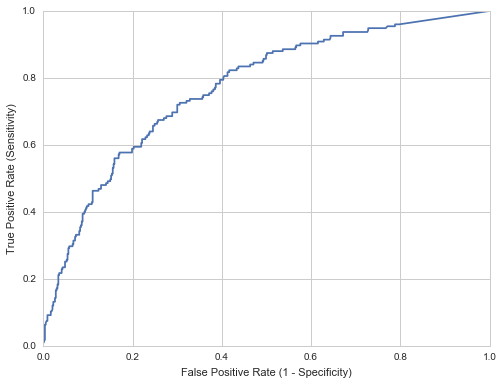

In [79]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1183d99d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x117132390>], dtype=object)

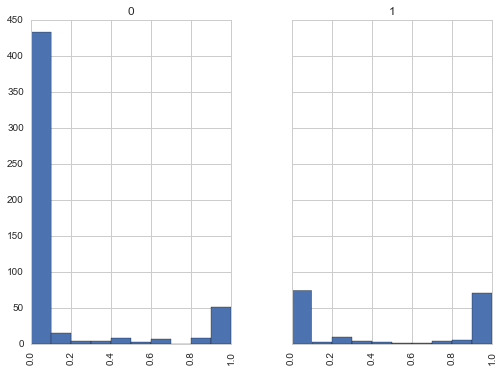

In [80]:
# histogram of predicted probabilities grouped by actual response value
df = pd.DataFrame({'probability':y_pred_prob, 'actual':y_test})
df.hist(column='probability', by='actual', sharex=True, sharey=True)

In [81]:
# calculate AUC
print metrics.roc_auc_score(y_test, y_pred_prob)

0.76968641115


In [82]:
# calculate cross-validated AUC
#cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

### Sentiment Analysis

In [83]:
# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [84]:
# create a new DataFrame column for sentiment (WARNING: SLOW!)
wb['sentiment'] = wb.text_clean.apply(detect_sentiment)
wb['ln_RT']=np.log(wb.retweet_count+1)
wb['ln_fav']=np.log(wb.favorite_count+1)

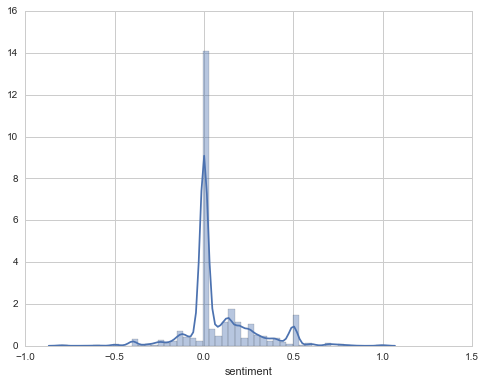

In [85]:
sns.distplot(wb.sentiment)

In [95]:
wb.year.value_counts()

15    2230
16     600
Name: year, dtype: int64

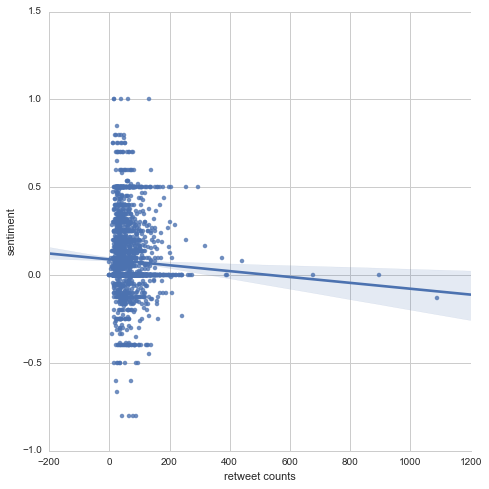

In [106]:
# Plot tip as a function of toal bill across days
g = sns.lmplot(x="retweet_count", y="sentiment", data=wb, size=7)

# Use more informative axis labels than are provided by default
g.set_axis_labels("retweet counts", "sentiment")

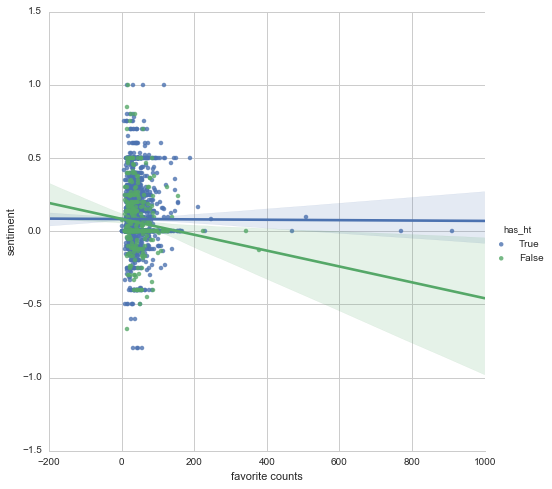

In [87]:
# Plot tip as a function of toal bill across days
g = sns.lmplot(x="favorite_count", y="sentiment", hue="has_ht", data=wb, size=7)

# Use more informative axis labels than are provided by default
g.set_axis_labels("favorite counts", "sentiment")

In [88]:
# list reviews with most positive sentiment
wb[wb.sentiment == 1].text.head()

356     Tourism leads to entry-level jobs that allow p...
1197    Government works best when citizens are engage...
1631    What is the best news in the world today, acco...
1779    "One person's trash is another person's treasu...
2096    “Chefs are the best weapons to bring about cha...
Name: text, dtype: object

In [89]:
# list reviews with most negative sentiment
wb[wb.sentiment <0].text.head()

1     When girls stay an extra yr in secondary schoo...
2     Among the poor, 78% live in rural areas, &amp;...
11    &gt; 200 M ppl could experience less coastal f...
24    #Climatechange could impact coral #reefs. This...
44    This small #Indian village proves ending extre...
Name: text, dtype: object